# Deep learning for timeseries

## Different kinds of timeseries tasks

## A temperature-forecasting example

In [60]:
!pip install tensorflow

In [61]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2025-11-01 23:58:20--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.48.160, 54.231.202.136, 52.216.60.184, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.48.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip.1’

jena_climate_2009_2 100%[===================>]  12.94M  --.-KB/s    in 0.07s   

2025-11-01 23:58:20 (188 MB/s) - ‘jena_climate_2009_2016.csv.zip.1’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
replace jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: jena_climate_2009_2016.csv  
replace __MACOSX/._jena_climate_2009_2016.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data of the Jena weather dataset**

In [65]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [66]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

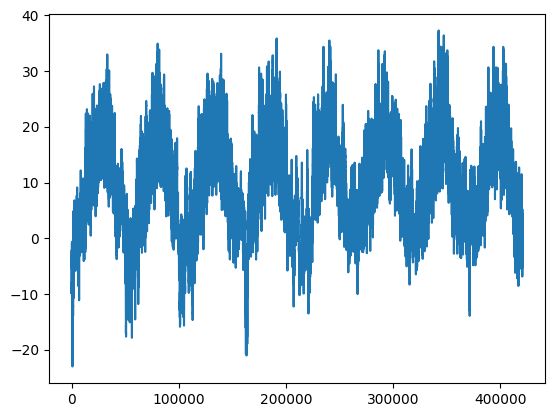

In [67]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

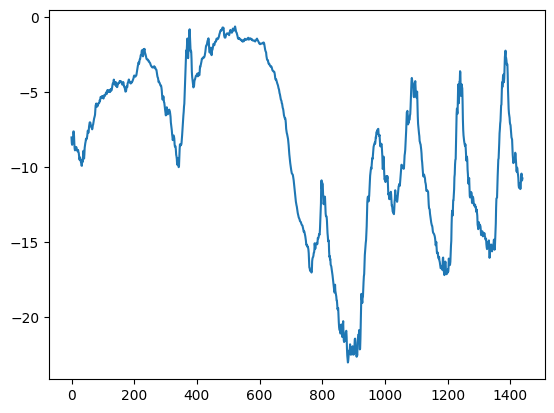

In [68]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

In [69]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

**Normalizing the data**

In [70]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [71]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**

In [72]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [73]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

In [74]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


**Model 1**

### Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

In [75]:
from tensorflow import keras
from tensorflow.keras import layers

# Example input shape (adjust according to dataset structure)
sequence_length = 10  # Adjust according to dataset
feature_dim = raw_data.shape[-1]  # Ensure raw_data is defined

# Define the model
inputs = keras.Input(shape=(sequence_length, feature_dim))
x = layers.GlobalAveragePooling1D()(inputs)  # Replaces Flatten for sequence data
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

# Callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras", save_best_only=True)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(
    train_dataset,  # Ensure train_dataset is properly formatted
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

# Load and evaluate the best model
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")
print(f"Validation MAE: {min(history.history['val_mae']):.2f}")


Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 55s 65ms/step - loss: 82.8937 - mae: 7.2830 - val_loss: 25.0175 - val_mae: 3.9661
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 54s 65ms/step - loss: 23.6506 - mae: 3.8724 - val_loss: 20.6541 - val_mae: 3.5942
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 53s 65ms/step - loss: 21.9312 - mae: 3.7445 - val_loss: 20.5272 - val_mae: 3.5791
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 53s 65ms/step - loss: 21.7640 - mae: 3.7294 - val_loss: 20.5332 - val_mae: 3.5735
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 54s 65ms/step - loss: 21.6579 - mae: 3.7207 - val_loss: 20.4467 - val_mae: 3.5650
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 54s 65ms/step - loss: 21.5334 - mae: 3.7099 - val_loss: 20.6161 - val_mae: 3.5761
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 52s 63ms/step - loss: 21.4485 - mae: 3.7015 - val_loss: 20.6928 - val_mae: 3.5847
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 53s 65ms/step - loss: 21.3516 - mae: 3.6931 - val_loss: 20.6840 - val_mae: 3.5852
Epoch 9/10
819/819 ━━━━━

**Plotting results**

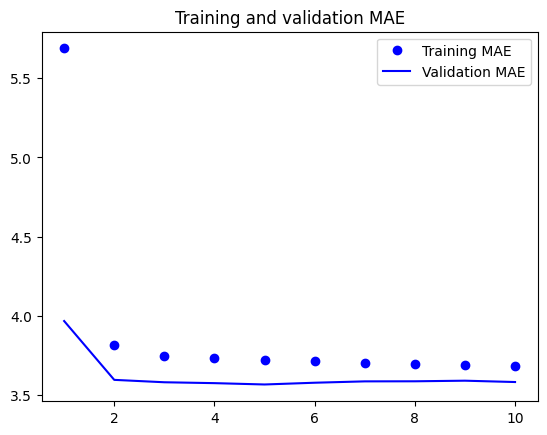

In [76]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

**Model 2**

LSTM model with three layers and 8 units

In [77]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers

# Define sequence length
sequence_length = 30

# Generate dummy raw_data (1000 samples, 10 features)
raw_data = np.random.rand(1000, 10)

# Define training, validation, and test split ratios
train_size = int(0.7 * len(raw_data))  # 70% for training
val_size = int(0.2 * len(raw_data))    # 20% for validation
test_size = len(raw_data) - (train_size + val_size)  # Remaining 10% for testing

# Function to create dataset
def create_dataset(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : i + sequence_length])  # Past `sequence_length` steps
        y.append(data[i + sequence_length, 0])   # Predict the first feature
    return np.array(X), np.array(y)

# Split data into train, validation, and test
train_data, train_labels = create_dataset(raw_data[:train_size], sequence_length)
val_data, val_labels = create_dataset(raw_data[train_size : train_size + val_size], sequence_length)
test_data, test_labels = create_dataset(raw_data[train_size + val_size:], sequence_length)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).batch(32)

# Define model input
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

# Add three LSTM layers with 8 units each
x = layers.LSTM(8, return_sequences=True)(inputs)
x = layers.LSTM(8, return_sequences=True)(x)
x = layers.LSTM(8)(x)

# Output layer
outputs = layers.Dense(1)(x)

# Create the model
model = keras.Model(inputs, outputs)

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

# Load the best model and evaluate
model = keras.models.load_model("jena_lstm.keras")
test_mae = model.evaluate(test_dataset)[1]
val_mae = min(history.history['val_mae'])
print(f"Test MAE: {test_mae:.2f}")
print(f"Validation MAE: {val_mae:.2f}")


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 0.1001 - mae: 0.2671 - val_loss: 0.0812 - val_mae: 0.2430
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0849 - mae: 0.2511 - val_loss: 0.0812 - val_mae: 0.2430
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0849 - mae: 0.2511 - val_loss: 0.0811 - val_mae: 0.2430
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0848 - mae: 0.2511 - val_loss: 0.0811 - val_mae: 0.2430
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0847 - mae: 0.2510 - val_loss: 0.0811 - val_mae: 0.2430
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0847 - mae: 0.2510 - val_loss: 0.0810 - val_mae: 0.2431
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0846 - mae: 0.2509 - val_loss: 0.0810 - val_mae: 0.2431
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0846 - mae: 0.2509 - val_loss: 0.0810 - val_mae: 0.2431
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.084

**Plotting results**

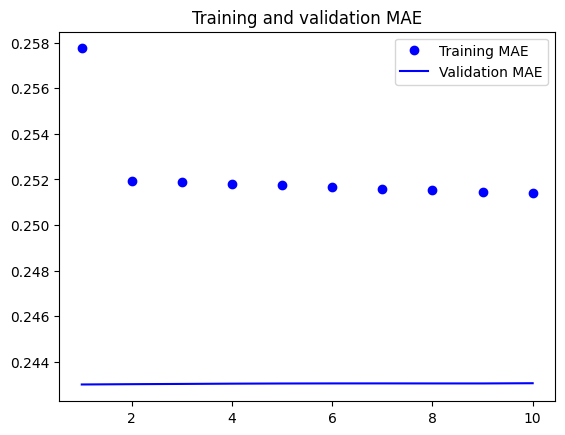

In [78]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

**Model 3**

LSTM model with three layers and 16 units

In [79]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers

# Define sequence length
sequence_length = 30

# Generate dummy raw_data (1000 samples, 10 features)
raw_data = np.random.rand(1000, 10)

# Define training, validation, and test split ratios
train_size = int(0.7 * len(raw_data))  # 70% for training
val_size = int(0.2 * len(raw_data))    # 20% for validation
test_size = len(raw_data) - (train_size + val_size)  # Remaining 10% for testing

# Function to create dataset
def create_dataset(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : i + sequence_length])  # Past `sequence_length` steps
        y.append(data[i + sequence_length, 0])   # Predict the first feature
    return np.array(X), np.array(y)

# Split data into train, validation, and test
train_data, train_labels = create_dataset(raw_data[:train_size], sequence_length)
val_data, val_labels = create_dataset(raw_data[train_size : train_size + val_size], sequence_length)
test_data, test_labels = create_dataset(raw_data[train_size + val_size:], sequence_length)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).batch(32)

# Define model input
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

# Add three LSTM layers with 16 units each
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(16, return_sequences=True)(x)
x = layers.LSTM(16)(x)

# Output layer
outputs = layers.Dense(1)(x)

# Create the model
model = keras.Model(inputs, outputs)

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

# Load the best model and evaluate
model = keras.models.load_model("jena_lstm.keras")
test_mae = model.evaluate(test_dataset)[1]
val_mae = min(history.history['val_mae'])
print(f"Test MAE: {test_mae:.2f}")
print(f"Validation MAE: {val_mae:.2f}")


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - loss: 0.1526 - mae: 0.3171 - val_loss: 0.0855 - val_mae: 0.2553
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0840 - mae: 0.2503 - val_loss: 0.0858 - val_mae: 0.2555
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0838 - mae: 0.2503 - val_loss: 0.0858 - val_mae: 0.2555
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0836 - mae: 0.2502 - val_loss: 0.0858 - val_mae: 0.2554
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0835 - mae: 0.2502 - val_loss: 0.0857 - val_mae: 0.2554
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0834 - mae: 0.2502 - val_loss: 0.0857 - val_mae: 0.2553
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0833 - mae: 0.2501 - val_loss: 0.0857 - val_mae: 0.2553
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0832 - mae: 0.2501 - val_loss: 0.0857 - val_mae: 0.2552
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.083

**Plotting results**

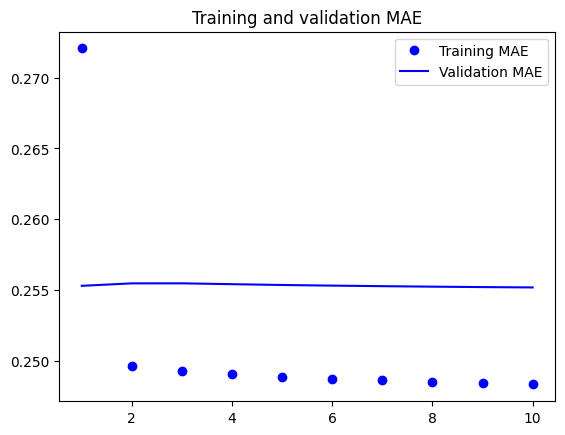

In [80]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

**Model 4**

LSTM model with three layers and 32 units

In [81]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers

# Define sequence length
sequence_length = 30

# Generate dummy raw_data (1000 samples, 10 features)
raw_data = np.random.rand(1000, 10)

# Define training, validation, and test split ratios
train_size = int(0.7 * len(raw_data))  # 70% for training
val_size = int(0.2 * len(raw_data))    # 20% for validation
test_size = len(raw_data) - (train_size + val_size)  # Remaining 10% for testing

# Function to create dataset
def create_dataset(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : i + sequence_length])  # Past `sequence_length` steps
        y.append(data[i + sequence_length, 0])   # Predict the first feature
    return np.array(X), np.array(y)

# Split data into train, validation, and test
train_data, train_labels = create_dataset(raw_data[:train_size], sequence_length)
val_data, val_labels = create_dataset(raw_data[train_size : train_size + val_size], sequence_length)
test_data, test_labels = create_dataset(raw_data[train_size + val_size:], sequence_length)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).batch(32)

# Define model input
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

# Add three LSTM layers with 32 units each
x = layers.LSTM(32, return_sequences=True)(inputs)
x = layers.LSTM(32, return_sequences=True)(x)
x = layers.LSTM(32)(x)

# Output layer
outputs = layers.Dense(1)(x)

# Create the model
model = keras.Model(inputs, outputs)

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

# Load the best model and evaluate
model = keras.models.load_model("jena_lstm.keras")
test_mae = model.evaluate(test_dataset)[1]
val_mae = min(history.history['val_mae'])
print(f"Test MAE: {test_mae:.2f}")
print(f"Validation MAE: {val_mae:.2f}")


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - loss: 0.2008 - mae: 0.3556 - val_loss: 0.0922 - val_mae: 0.2657
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0918 - mae: 0.2626 - val_loss: 0.0919 - val_mae: 0.2653
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0910 - mae: 0.2623 - val_loss: 0.0917 - val_mae: 0.2649
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0904 - mae: 0.2619 - val_loss: 0.0915 - val_mae: 0.2647
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0900 - mae: 0.2617 - val_loss: 0.0914 - val_mae: 0.2644
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0896 - mae: 0.2615 - val_loss: 0.0912 - val_mae: 0.2642
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - loss: 0.0894 - mae: 0.2613 - val_loss: 0.0910 - val_mae: 0.2640
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0891 - mae: 0.2611 - val_loss: 0.0908 - val_mae: 0.2638
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.088

**Plotting results**

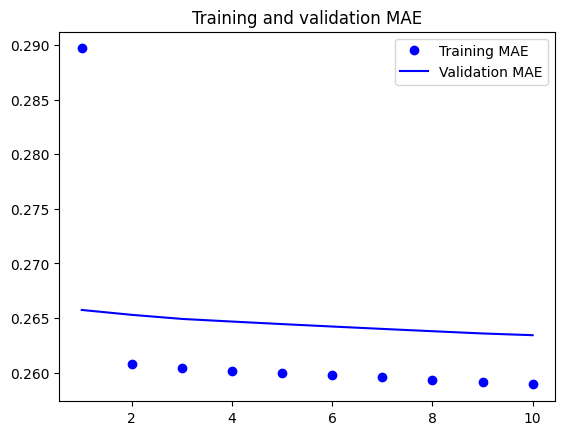

In [82]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

**Model 5**

LSTM model with four layers with 16 units

In [83]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers

# Define sequence length
sequence_length = 30

# Generate dummy raw_data (1000 samples, 10 features)
raw_data = np.random.rand(1000, 10)

# Define training, validation, and test split ratios
train_size = int(0.7 * len(raw_data))  # 70% for training
val_size = int(0.2 * len(raw_data))    # 20% for validation
test_size = len(raw_data) - (train_size + val_size)  # Remaining 10% for testing

# Function to create dataset
def create_dataset(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : i + sequence_length])  # Past `sequence_length` steps
        y.append(data[i + sequence_length, 0])   # Predict the first feature
    return np.array(X), np.array(y)

# Split data into train, validation, and test
train_data, train_labels = create_dataset(raw_data[:train_size], sequence_length)
val_data, val_labels = create_dataset(raw_data[train_size : train_size + val_size], sequence_length)
test_data, test_labels = create_dataset(raw_data[train_size + val_size:], sequence_length)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).batch(32)

# Define model input
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

# Add four LSTM layers with 16 units each
x = layers.LSTM(16, return_sequences=True)(inputs)
x = layers.LSTM(16, return_sequences=True)(x)
x = layers.LSTM(16, return_sequences=True)(x)
x = layers.LSTM(16)(x)

# Output layer
outputs = layers.Dense(1)(x)

# Create the model
model = keras.Model(inputs, outputs)

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras", save_best_only=True)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

# Load the best model and evaluate
model = keras.models.load_model("jena_lstm.keras")
test_mae = model.evaluate(test_dataset)[1]
val_mae = min(history.history['val_mae'])
print(f"Test MAE: {test_mae:.2f}")
print(f"Validation MAE: {val_mae:.2f}")


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - loss: 0.2307 - mae: 0.3952 - val_loss: 0.0906 - val_mae: 0.2601
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0922 - mae: 0.2650 - val_loss: 0.0909 - val_mae: 0.2606
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0922 - mae: 0.2651 - val_loss: 0.0910 - val_mae: 0.2604
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0917 - mae: 0.2646 - val_loss: 0.0909 - val_mae: 0.2601
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0913 - mae: 0.2641 - val_loss: 0.0908 - val_mae: 0.2598
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0910 - mae: 0.2636 - val_loss: 0.0906 - val_mae: 0.2596
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0907 - mae: 0.2633 - val_loss: 0.0905 - val_mae: 0.2593
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 0.0905 - mae: 0.2629 - val_loss: 0.0905 - val_mae: 0.2591
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.090

**Plotting results**

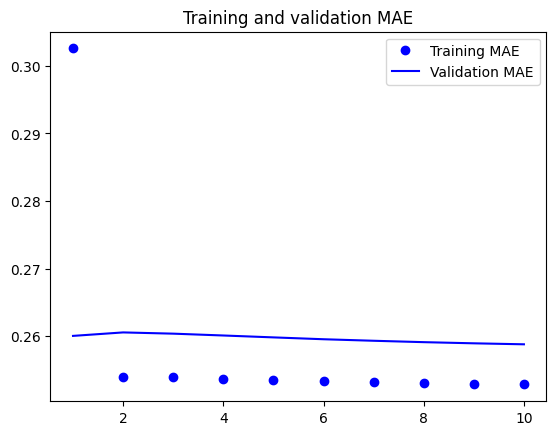

In [84]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

**Model 6**

Using gru three layers and 8 units

In [85]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt

# Define sequence length
sequence_length = 30

# Generate dummy raw_data (1000 samples, 10 features)
raw_data = np.random.rand(1000, 10)

# Define training, validation, and test split ratios
train_size = int(0.7 * len(raw_data))  # 70% for training
val_size = int(0.2 * len(raw_data))    # 20% for validation
test_size = len(raw_data) - (train_size + val_size)  # Remaining 10% for testing

# Function to create dataset
def create_dataset(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : i + sequence_length])  # Past `sequence_length` steps
        y.append(data[i + sequence_length, 0])   # Predict the first feature
    return np.array(X), np.array(y)

# Split data into train, validation, and test
train_data, train_labels = create_dataset(raw_data[:train_size], sequence_length)
val_data, val_labels = create_dataset(raw_data[train_size : train_size + val_size], sequence_length)
test_data, test_labels = create_dataset(raw_data[train_size + val_size:], sequence_length)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).batch(32)

# Define model input
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

# Add three GRU layers with 8 units each
x = layers.GRU(8, return_sequences=True)(inputs)
x = layers.GRU(8, return_sequences=True)(x)
x = layers.GRU(8)(x)

# Output layer
outputs = layers.Dense(1)(x)

# Create the model
model = keras.Model(inputs, outputs)

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras", save_best_only=True)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

# Load the best model and evaluate
model = keras.models.load_model("jena_gru.keras")
test_mae = model.evaluate(test_dataset)[1]
val_mae = min(history.history['val_mae'])
print(f"Test MAE: {test_mae:.2f}")
print(f"Validation MAE: {val_mae:.2f}")


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 0.1675 - mae: 0.3385 - val_loss: 0.0930 - val_mae: 0.2624
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0780 - mae: 0.2395 - val_loss: 0.0935 - val_mae: 0.2627
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0775 - mae: 0.2389 - val_loss: 0.0935 - val_mae: 0.2626
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0770 - mae: 0.2383 - val_loss: 0.0933 - val_mae: 0.2624
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0765 - mae: 0.2377 - val_loss: 0.0931 - val_mae: 0.2622
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0762 - mae: 0.2372 - val_loss: 0.0931 - val_mae: 0.2621
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0760 - mae: 0.2368 - val_loss: 0.0931 - val_mae: 0.2620
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0758 - mae: 0.2365 - val_loss: 0.0931 - val_mae: 0.2619
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.075

**Plotting results**

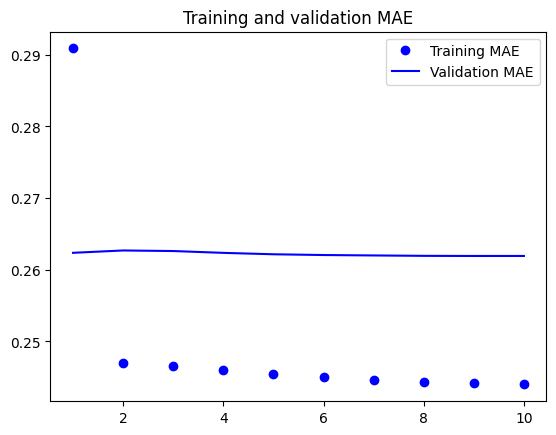

In [86]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

**Model 7**

Using gru three layers and 16 units

In [87]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt

# Define sequence length
sequence_length = 30

# Generate dummy raw_data (1000 samples, 10 features)
raw_data = np.random.rand(1000, 10)

# Define training, validation, and test split ratios
train_size = int(0.7 * len(raw_data))  # 70% for training
val_size = int(0.2 * len(raw_data))    # 20% for validation
test_size = len(raw_data) - (train_size + val_size)  # Remaining 10% for testing

# Function to create dataset
def create_dataset(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : i + sequence_length])  # Past `sequence_length` steps
        y.append(data[i + sequence_length, 0])   # Predict the first feature
    return np.array(X), np.array(y)

# Split data into train, validation, and test
train_data, train_labels = create_dataset(raw_data[:train_size], sequence_length)
val_data, val_labels = create_dataset(raw_data[train_size : train_size + val_size], sequence_length)
test_data, test_labels = create_dataset(raw_data[train_size + val_size:], sequence_length)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).batch(32)

# Define model input
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

# Add three GRU layers with 16 units each
x = layers.GRU(16, return_sequences=True)(inputs)
x = layers.GRU(16, return_sequences=True)(x)
x = layers.GRU(16)(x)

# Output layer
outputs = layers.Dense(1)(x)

# Create the model
model = keras.Model(inputs, outputs)

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras", save_best_only=True)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

# Load the best model and evaluate
model = keras.models.load_model("jena_gru.keras")
test_mae = model.evaluate(test_dataset)[1]
val_mae = min(history.history['val_mae'])
print(f"Test MAE: {test_mae:.2f}")
print(f"Validation MAE: {val_mae:.2f}")


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - loss: 0.1097 - mae: 0.2705 - val_loss: 0.0836 - val_mae: 0.2478
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0851 - mae: 0.2505 - val_loss: 0.0832 - val_mae: 0.2474
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0844 - mae: 0.2499 - val_loss: 0.0830 - val_mae: 0.2472
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0839 - mae: 0.2493 - val_loss: 0.0829 - val_mae: 0.2472
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0835 - mae: 0.2488 - val_loss: 0.0828 - val_mae: 0.2471
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0831 - mae: 0.2484 - val_loss: 0.0828 - val_mae: 0.2471
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0829 - mae: 0.2480 - val_loss: 0.0827 - val_mae: 0.2472
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0826 - mae: 0.2477 - val_loss: 0.0827 - val_mae: 0.2472
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.082

**Plotting results**

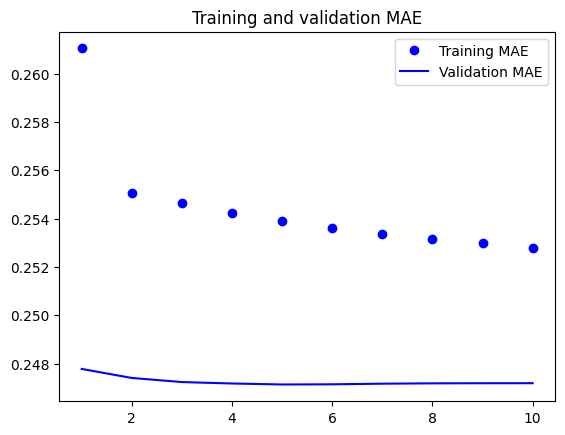

In [88]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

**Model 8**

Using gru with three layers and 32 units

In [89]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt

# Define sequence length
sequence_length = 30

# Generate dummy raw_data (1000 samples, 10 features)
raw_data = np.random.rand(1000, 10)

# Define training, validation, and test split ratios
train_size = int(0.7 * len(raw_data))  # 70% for training
val_size = int(0.2 * len(raw_data))    # 20% for validation
test_size = len(raw_data) - (train_size + val_size)  # Remaining 10% for testing

# Function to create dataset
def create_dataset(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : i + sequence_length])  # Past `sequence_length` steps
        y.append(data[i + sequence_length, 0])   # Predict the first feature
    return np.array(X), np.array(y)

# Split data into train, validation, and test
train_data, train_labels = create_dataset(raw_data[:train_size], sequence_length)
val_data, val_labels = create_dataset(raw_data[train_size : train_size + val_size], sequence_length)
test_data, test_labels = create_dataset(raw_data[train_size + val_size:], sequence_length)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).batch(32)

# Define model input
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))

# Add three GRU layers with 32 units each
x = layers.GRU(32, return_sequences=True)(inputs)
x = layers.GRU(32, return_sequences=True)(x)
x = layers.GRU(32)(x)

# Output layer
outputs = layers.Dense(1)(x)

# Create the model
model = keras.Model(inputs, outputs)

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras", save_best_only=True)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

# Load the best model and evaluate
model = keras.models.load_model("jena_gru.keras")
test_mae = model.evaluate(test_dataset)[1]
val_mae = min(history.history['val_mae'])
print(f"Test MAE: {test_mae:.2f}")
print(f"Validation MAE: {val_mae:.2f}")


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - loss: 0.1131 - mae: 0.2785 - val_loss: 0.1046 - val_mae: 0.2716
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0859 - mae: 0.2513 - val_loss: 0.1026 - val_mae: 0.2697
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0849 - mae: 0.2501 - val_loss: 0.0993 - val_mae: 0.2672
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0838 - mae: 0.2490 - val_loss: 0.0971 - val_mae: 0.2656
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0831 - mae: 0.2482 - val_loss: 0.0957 - val_mae: 0.2646
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 0.0826 - mae: 0.2475 - val_loss: 0.0949 - val_mae: 0.2642
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0822 - mae: 0.2470 - val_loss: 0.0943 - val_mae: 0.2641
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0820 - mae: 0.2467 - val_loss: 0.0939 - val_mae: 0.2640
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.081

**Plotting results**

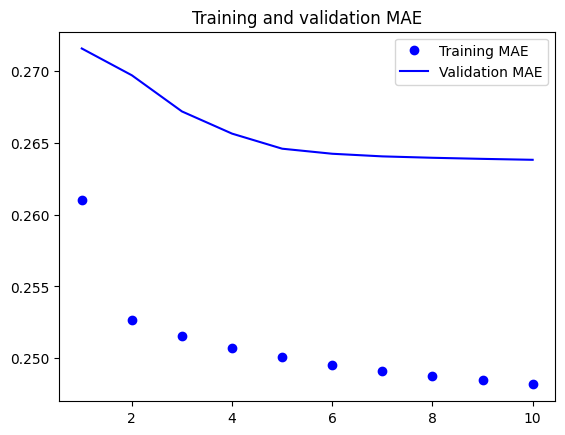

In [90]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

**Model 9**

Using gru four layers and 16 units

In [91]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt

# Define sequence length
sequence_length = 30

# Generate dummy raw_data (1000 samples, 10 features)
raw_data = np.random.rand(1000, 10)

# Define training, validation, and test split ratios
train_size = int(0.7 * len(raw_data))  # 70% for training
val_size = int(0.2 * len(raw_data))    # 20% for validation
test_size = len(raw_data) - (train_size + val_size)  # Remaining 10% for testing

# Function to create dataset
def create_dataset(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : i + sequence_length])  # Past `sequence_length` steps
        y.append(data[i + sequence_length, 0])   # Predict the first feature
    return np.array(X), np.array(y)

# Split data into train, validation, and test
train_data, train_labels = create_dataset(raw_data[:train_size], sequence_length)
val_data, val_labels = create_dataset(raw_data[train_size : train_size + val_size], sequence_length)
test_data, test_labels = create_dataset(raw_data[train_size + val_size:], sequence_length)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).batch(32)

# Define model input
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(16, return_sequences=True)(inputs)
x = layers.GRU(16, return_sequences=True)(x)
x = layers.GRU(16, return_sequences=True)(x)
x = layers.GRU(16)(x)
outputs = layers.Dense(1)(x)

# Create the model
model = keras.Model(inputs, outputs)

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_gru.keras", save_best_only=True)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

# Load the best model and evaluate
model = keras.models.load_model("jena_gru.keras")
test_mae = model.evaluate(test_dataset)[1]
val_mae = min(history.history['val_mae'])
print(f"Test MAE: {test_mae:.2f}")
print(f"Validation MAE: {val_mae:.2f}")


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 0.2161 - mae: 0.3779 - val_loss: 0.0935 - val_mae: 0.2714
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0812 - mae: 0.2441 - val_loss: 0.0935 - val_mae: 0.2714
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0818 - mae: 0.2449 - val_loss: 0.0933 - val_mae: 0.2711
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0815 - mae: 0.2445 - val_loss: 0.0932 - val_mae: 0.2709
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0812 - mae: 0.2440 - val_loss: 0.0931 - val_mae: 0.2708
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0809 - mae: 0.2437 - val_loss: 0.0931 - val_mae: 0.2707
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0806 - mae: 0.2434 - val_loss: 0.0931 - val_mae: 0.2706
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0804 - mae: 0.2431 - val_loss: 0.0931 - val_mae: 0.2706
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 90ms/step - loss: 0.08

**Plotting results**

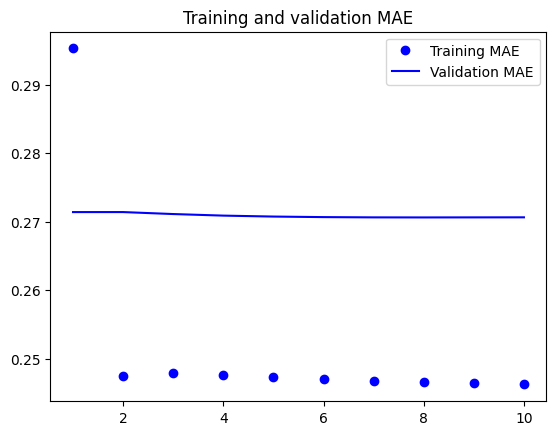

In [92]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]

epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

**Model 10**

Using 1D Convolution and LSTM

In [93]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt

# Define sequence length
sequence_length = 30

# Generate dummy raw_data (1000 samples, 10 features)
raw_data = np.random.rand(1000, 10)

# Define training, validation, and test split ratios
train_size = int(0.7 * len(raw_data))
val_size = int(0.2 * len(raw_data))
test_size = len(raw_data) - (train_size + val_size)

# Function to create dataset
def create_dataset(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : i + sequence_length])
        y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(y)

# Split data into train, validation, and test
train_data, train_labels = create_dataset(raw_data[:train_size], sequence_length)
val_data, val_labels = create_dataset(raw_data[train_size : train_size + val_size], sequence_length)
test_data, test_labels = create_dataset(raw_data[train_size + val_size:], sequence_length)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).batch(32)

# Define model input
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(filters=32, kernel_size=3, activation='relu')(inputs)
# Set return_sequences=True for the first LSTM layer
x = layers.LSTM(32, return_sequences=True)(x)  # Change here
x = layers.LSTM(32)(x)
outputs = layers.Dense(1)(x)

# Create the model
model = keras.Model(inputs, outputs)

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_cnn_lstm.keras", save_best_only=True)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

# Load the best model and evaluate
model = keras.models.load_model("jena_cnn_lstm.keras")
test_mae = model.evaluate(test_dataset)[1]
val_mae = min(history.history['val_mae'])
print(f"Test MAE: {test_mae:.2f}")
print(f"Validation MAE: {val_mae:.2f}")

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - loss: 0.1438 - mae: 0.3049 - val_loss: 0.0845 - val_mae: 0.2481
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0868 - mae: 0.2539 - val_loss: 0.0844 - val_mae: 0.2480
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0858 - mae: 0.2527 - val_loss: 0.0843 - val_mae: 0.2479
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0849 - mae: 0.2517 - val_loss: 0.0842 - val_mae: 0.2477
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0843 - mae: 0.2510 - val_loss: 0.0840 - val_mae: 0.2475
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0839 - mae: 0.2504 - val_loss: 0.0840 - val_mae: 0.2474
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0835 - mae: 0.2500 - val_loss: 0.0839 - val_mae: 0.2473
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0833 - mae: 0.2498 - val_loss: 0.0838 - val_mae: 0.2471
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.083

**Plotting results**

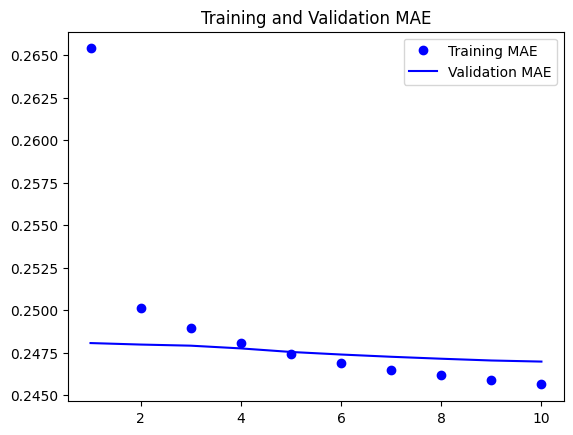

In [94]:
# Plotting MAE like the given example
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()


**Model 11**

Using 1D Convolution and simple RNN

In [95]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt

# Define sequence length
sequence_length = 30

# Generate dummy raw_data (1000 samples, 10 features)
raw_data = np.random.rand(1000, 10)

# Define training, validation, and test split ratios
train_size = int(0.7 * len(raw_data))  # 70% for training
val_size = int(0.2 * len(raw_data))    # 20% for validation
test_size = len(raw_data) - (train_size + val_size)  # Remaining 10% for testing

# Function to create dataset
def create_dataset(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : i + sequence_length])  # Past `sequence_length` steps
        y.append(data[i + sequence_length, 0])   # Predict the first feature
    return np.array(X), np.array(y)

# Split data into train, validation, and test
train_data, train_labels = create_dataset(raw_data[:train_size], sequence_length)
val_data, val_labels = create_dataset(raw_data[train_size : train_size + val_size], sequence_length)
test_data, test_labels = create_dataset(raw_data[train_size + val_size:], sequence_length)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).batch(32)

# Define model input
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(filters=32, kernel_size=3, activation='relu')(inputs)
x = layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = layers.SimpleRNN(32, return_sequences=True)(x)
x = layers.SimpleRNN(32, return_sequences=True)(x)
x = layers.SimpleRNN(32)(x)
outputs = layers.Dense(1)(x)

# Create the model
model = keras.Model(inputs, outputs)

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_cnn_rnn.keras", save_best_only=True)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

# Load the best model and evaluate
model = keras.models.load_model("jena_cnn_rnn.keras")
test_mae = model.evaluate(test_dataset)[1]
val_mae = min(history.history['val_mae'])
print(f"Test MAE: {test_mae:.2f}")
print(f"Validation MAE: {val_mae:.2f}")



Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.1644 - mae: 0.3325 - val_loss: 0.0991 - val_mae: 0.2742
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0906 - mae: 0.2584 - val_loss: 0.0986 - val_mae: 0.2735
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0887 - mae: 0.2562 - val_loss: 0.0983 - val_mae: 0.2729
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0873 - mae: 0.2543 - val_loss: 0.0978 - val_mae: 0.2726
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0856 - mae: 0.2516 - val_loss: 0.0987 - val_mae: 0.2729
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0843 - mae: 0.2488 - val_loss: 0.1014 - val_mae: 0.2746
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0829 - mae: 0.2455 - val_loss: 0.1114 - val_mae: 0.2804
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0829 - mae: 0.2438 - val_loss: 0.1168 - val_mae: 0.2869
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.081

**Plotting results**

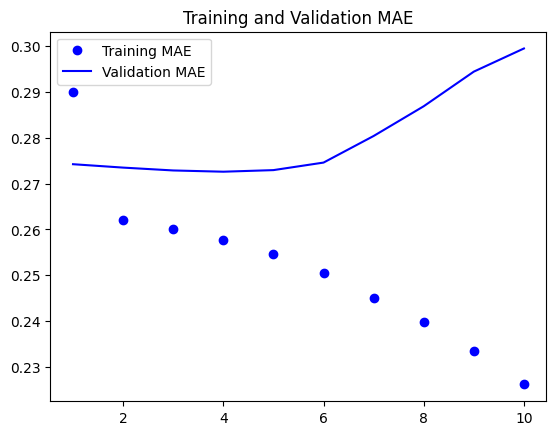

In [96]:
# Plotting MAE like the given example
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()


**Model 12**

Using 1D Convolution and GRU

In [97]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt

# Define sequence length
sequence_length = 30

# Generate dummy raw_data (1000 samples, 10 features)
raw_data = np.random.rand(1000, 10)

# Define training, validation, and test split ratios
train_size = int(0.7 * len(raw_data))  # 70% for training
val_size = int(0.2 * len(raw_data))    # 20% for validation
test_size = len(raw_data) - (train_size + val_size)  # Remaining 10% for testing

# Function to create dataset
def create_dataset(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : i + sequence_length])  # Past `sequence_length` steps
        y.append(data[i + sequence_length, 0])   # Predict the first feature
    return np.array(X), np.array(y)

# Split data into train, validation, and test
train_data, train_labels = create_dataset(raw_data[:train_size], sequence_length)
val_data, val_labels = create_dataset(raw_data[train_size : train_size + val_size], sequence_length)
test_data, test_labels = create_dataset(raw_data[train_size + val_size:], sequence_length)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).batch(32)

# Define model input
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(inputs)
x = layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = layers.GRU(32, return_sequences=True)(x)
x = layers.GRU(32, return_sequences=True)(x)
x = layers.GRU(32)(x)
outputs = layers.Dense(1)(x)

# Create the model
model = keras.Model(inputs, outputs)

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_cnn_gru.keras", save_best_only=True)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

# Load the best model and evaluate
model = keras.models.load_model("jena_cnn_gru.keras")
test_mae = model.evaluate(test_dataset)[1]
val_mae = min(history.history['val_mae'])
print(f"Test MAE: {test_mae:.2f}")
print(f"Validation MAE: {val_mae:.2f}")



Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - loss: 0.1550 - mae: 0.3229 - val_loss: 0.0935 - val_mae: 0.2591
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0880 - mae: 0.2544 - val_loss: 0.0921 - val_mae: 0.2580
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.0873 - mae: 0.2536 - val_loss: 0.0908 - val_mae: 0.2569
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0866 - mae: 0.2529 - val_loss: 0.0898 - val_mae: 0.2562
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0861 - mae: 0.2522 - val_loss: 0.0889 - val_mae: 0.2555
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0855 - mae: 0.2516 - val_loss: 0.0884 - val_mae: 0.2551
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0851 - mae: 0.2511 - val_loss: 0.0879 - val_mae: 0.2548
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0846 - mae: 0.2506 - val_loss: 0.0876 - val_mae: 0.2546
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.084

**Plotting results**

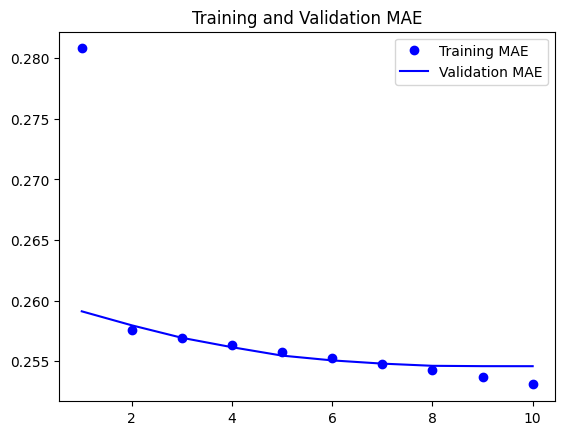

In [98]:
# Plotting MAE like the given example
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()


**Model 13**

Using 1D Convolution, LSTM and Dropout

In [99]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt

# Define sequence length
sequence_length = 30

# Generate dummy raw_data (1000 samples, 10 features)
raw_data = np.random.rand(1000, 10)

# Define training, validation, and test split ratios
train_size = int(0.7 * len(raw_data))  # 70% for training
val_size = int(0.2 * len(raw_data))    # 20% for validation
test_size = len(raw_data) - (train_size + val_size)  # Remaining 10% for testing

# Function to create dataset
def create_dataset(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : i + sequence_length])  # Past `sequence_length` steps
        y.append(data[i + sequence_length, 0])   # Predict the first feature
    return np.array(X), np.array(y)

# Split data into train, validation, and test
train_data, train_labels = create_dataset(raw_data[:train_size], sequence_length)
val_data, val_labels = create_dataset(raw_data[train_size : train_size + val_size], sequence_length)
test_data, test_labels = create_dataset(raw_data[train_size + val_size:], sequence_length)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).batch(32)

# Define model input
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(inputs)
x = layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(x)
x = layers.LSTM(32, return_sequences=True)(x)
x = layers.Dropout(0.5)(x)
x = layers.LSTM(32)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)

# Create the model
model = keras.Model(inputs, outputs)

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_cnn_lstm_dropout.keras", save_best_only=True)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

# Load the best model and evaluate
model = keras.models.load_model("jena_cnn_lstm_dropout.keras")
test_mae = model.evaluate(test_dataset)[1]
val_mae = min(history.history['val_mae'])
print(f"Test MAE: {test_mae:.2f}")
print(f"Validation MAE: {val_mae:.2f}")


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.1224 - mae: 0.2905 - val_loss: 0.1005 - val_mae: 0.2734
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.1097 - mae: 0.2732 - val_loss: 0.0938 - val_mae: 0.2687
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.1000 - mae: 0.2714 - val_loss: 0.0976 - val_mae: 0.2709
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.1025 - mae: 0.2692 - val_loss: 0.0924 - val_mae: 0.2672
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.1015 - mae: 0.2699 - val_loss: 0.0924 - val_mae: 0.2670
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0976 - mae: 0.2649 - val_loss: 0.0955 - val_mae: 0.2687
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0963 - mae: 0.2638 - val_loss: 0.0928 - val_mae: 0.2666
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0959 - mae: 0.2622 - val_loss: 0.0943 - val_mae: 0.2671
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.089

**Plotting results**

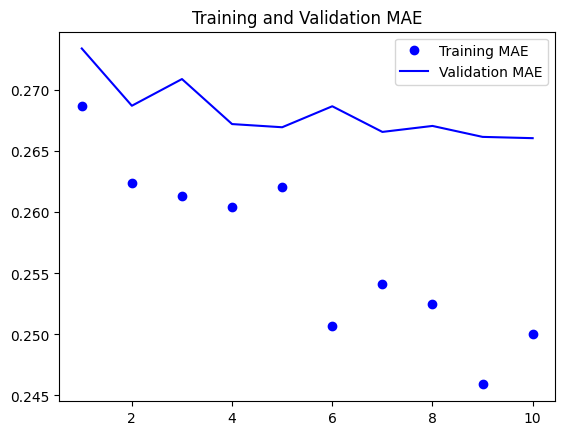

In [100]:
# Plotting MAE like the given example
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()


**Model 14**

Using 1D Convolution, Simple RNN and Dropout

In [101]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt

# Define sequence length
sequence_length = 30

# Generate dummy raw_data (1000 samples, 10 features)
raw_data = np.random.rand(1000, 10)

# Define training, validation, and test split ratios
train_size = int(0.7 * len(raw_data))  # 70% for training
val_size = int(0.2 * len(raw_data))    # 20% for validation
test_size = len(raw_data) - (train_size + val_size)  # Remaining 10% for testing

# Function to create dataset
def create_dataset(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : i + sequence_length])  # Past `sequence_length` steps
        y.append(data[i + sequence_length, 0])   # Predict the first feature
    return np.array(X), np.array(y)

# Split data into train, validation, and test
train_data, train_labels = create_dataset(raw_data[:train_size], sequence_length)
val_data, val_labels = create_dataset(raw_data[train_size : train_size + val_size], sequence_length)
test_data, test_labels = create_dataset(raw_data[train_size + val_size:], sequence_length)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).batch(32)

# Define model input
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(filters=16, kernel_size=3, activation='relu', padding='same')(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
x = layers.Dropout(0.5)(x)
x = layers.SimpleRNN(16)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)

# Create the model
model = keras.Model(inputs, outputs)

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_cnn_rnn_dropout.keras", save_best_only=True)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

# Load the best model and evaluate
model = keras.models.load_model("jena_cnn_rnn_dropout.keras")
test_mae = model.evaluate(test_dataset)[1]
val_mae = min(history.history['val_mae'])
print(f"Test MAE: {test_mae:.2f}")
print(f"Validation MAE: {val_mae:.2f}")


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - loss: 1.1868 - mae: 0.8736 - val_loss: 0.3045 - val_mae: 0.4481
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9251 - mae: 0.7745 - val_loss: 0.1927 - val_mae: 0.3531
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7588 - mae: 0.6914 - val_loss: 0.1853 - val_mae: 0.3530
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.6388 - mae: 0.6381 - val_loss: 0.1328 - val_mae: 0.3051
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5701 - mae: 0.6184 - val_loss: 0.1387 - val_mae: 0.3120
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4883 - mae: 0.5592 - val_loss: 0.1180 - val_mae: 0.2938
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.3752 - mae: 0.4991 - val_loss: 0.1151 - val_mae: 0.2903
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3479 - mae: 0.4850 - val_loss: 0.1075 - val_mae: 0.2844
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.295

**Plotting results**

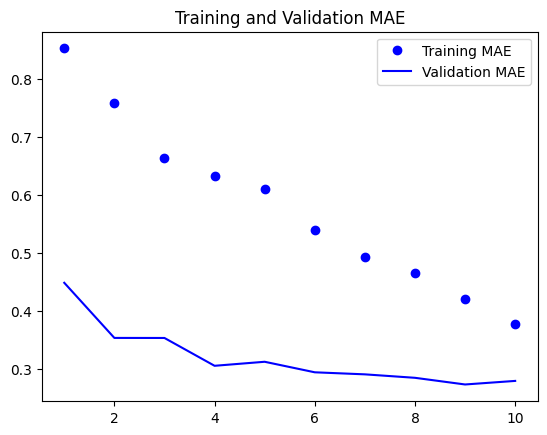

In [102]:
# Plotting MAE like the given example
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()


**Model 15**

Using 1D Convolution, GRU and Dropout

In [103]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt

# Define sequence length
sequence_length = 30

# Generate dummy raw_data (1000 samples, 10 features)
raw_data = np.random.rand(1000, 10)

# Define training, validation, and test split ratios
train_size = int(0.7 * len(raw_data))  # 70% for training
val_size = int(0.2 * len(raw_data))    # 20% for validation
test_size = len(raw_data) - (train_size + val_size)  # Remaining 10% for testing

# Function to create dataset
def create_dataset(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : i + sequence_length])  # Past `sequence_length` steps
        y.append(data[i + sequence_length, 0])   # Predict the first feature
    return np.array(X), np.array(y)

# Split data into train, validation, and test
train_data, train_labels = create_dataset(raw_data[:train_size], sequence_length)
val_data, val_labels = create_dataset(raw_data[train_size : train_size + val_size], sequence_length)
test_data, test_labels = create_dataset(raw_data[train_size + val_size:], sequence_length)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).batch(32)

# Define model input
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(inputs)
x = layers.GRU(32, return_sequences=True)(x)
x = layers.Dropout(0.5)(x)
x = layers.GRU(32)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)

# Create the model
model = keras.Model(inputs, outputs)

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_cnn_gru_dropout.keras", save_best_only=True)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

# Load the best model and evaluate
model = keras.models.load_model("jena_cnn_gru_dropout.keras")
test_mae = model.evaluate(test_dataset)[1]
val_mae = min(history.history['val_mae'])
print(f"Test MAE: {test_mae:.2f}")
print(f"Validation MAE: {val_mae:.2f}")

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - loss: 0.1736 - mae: 0.3327 - val_loss: 0.0766 - val_mae: 0.2370
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0997 - mae: 0.2624 - val_loss: 0.0849 - val_mae: 0.2424
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0975 - mae: 0.2648 - val_loss: 0.0815 - val_mae: 0.2402
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.1030 - mae: 0.2746 - val_loss: 0.0767 - val_mae: 0.2369
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0928 - mae: 0.2550 - val_loss: 0.0786 - val_mae: 0.2384
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0985 - mae: 0.2663 - val_loss: 0.0813 - val_mae: 0.2405
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0978 - mae: 0.2657 - val_loss: 0.0785 - val_mae: 0.2386
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0995 - mae: 0.2704 - val_loss: 0.0789 - val_mae: 0.2389
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.095

**Plotting results**

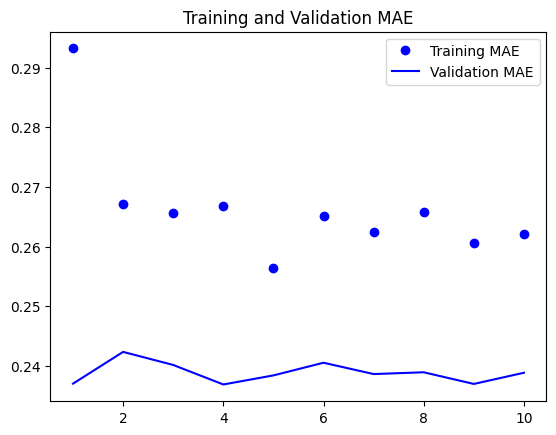

In [104]:
# Plotting MAE like the given example
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()

**Model 16**

Use Bidirectional GRU layers and Dropout

In [105]:
import numpy as np
import tensorflow as tf
import keras
from keras import layers
import matplotlib.pyplot as plt

# Define sequence length
sequence_length = 30

# Generate dummy raw_data (1000 samples, 10 features)
raw_data = np.random.rand(1000, 10)

# Define training, validation, and test split ratios
train_size = int(0.7 * len(raw_data))  # 70% for training
val_size = int(0.2 * len(raw_data))    # 20% for validation
test_size = len(raw_data) - (train_size + val_size)  # Remaining 10% for testing

# Function to create dataset
def create_dataset(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i : i + sequence_length])  # Past `sequence_length` steps
        y.append(data[i + sequence_length, 0])   # Predict the first feature
    return np.array(X), np.array(y)

# Split data into train, validation, and test
train_data, train_labels = create_dataset(raw_data[:train_size], sequence_length)
val_data, val_labels = create_dataset(raw_data[train_size : train_size + val_size], sequence_length)
test_data, test_labels = create_dataset(raw_data[train_size + val_size:], sequence_length)

# Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels)).batch(32)

# Define model input
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.GRU(16, return_sequences=True))(inputs)
x = layers.Dropout(0.5)(x)
x = layers.Bidirectional(layers.GRU(16, return_sequences=True))(x)
x = layers.Dropout(0.5)(x)
x = layers.Bidirectional(layers.GRU(16))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)

# Create the model
model = keras.Model(inputs, outputs)

# Define callbacks
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_bidirectional_gru.keras", save_best_only=True)
]

# Compile the model
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks
)

# Load the best model and evaluate
model = keras.models.load_model("jena_bidirectional_gru.keras")
test_mae = model.evaluate(test_dataset)[1]
val_mae = min(history.history['val_mae'])
print(f"Test MAE: {test_mae:.2f}")
print(f"Validation MAE: {val_mae:.2f}")


Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 186ms/step - loss: 0.2164 - mae: 0.3786 - val_loss: 0.0893 - val_mae: 0.2553
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.1518 - mae: 0.3211 - val_loss: 0.0887 - val_mae: 0.2552
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.1349 - mae: 0.3066 - val_loss: 0.0896 - val_mae: 0.2576
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.1227 - mae: 0.2939 - val_loss: 0.0898 - val_mae: 0.2571
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - loss: 0.1261 - mae: 0.2963 - val_loss: 0.0890 - val_mae: 0.2554
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.1161 - mae: 0.2832 - val_loss: 0.0896 - val_mae: 0.2567
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - loss: 0.1121 - mae: 0.2837 - val_loss: 0.0887 - val_mae: 0.2544
Epoch 8/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step - loss: 0.1054 - mae: 0.2742 - val_loss: 0.0888 - val_mae: 0.2547
Epoch 9/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - loss: 0.

**Plotting results**

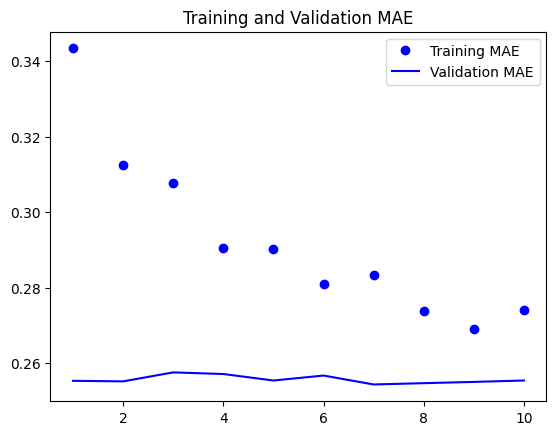

In [106]:
# Plotting MAE like the given example
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and Validation MAE")
plt.legend()
plt.show()